In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import kagglehub
import os
import ast
from collections import Counter
from scipy.stats import gaussian_kde

In [35]:
path = kagglehub.dataset_download("odedgolden/movielens-1m-dataset")
movies_path = os.path.join(path, "movies.dat")
ratings_path = os.path.join(path, "ratings.dat")
users_path = os.path.join(path, "users.dat")

In [36]:
df_movies = pd.read_csv(movies_path, sep="::", engine="python", encoding="ISO-8859-1", names=["movie_id", "title", "genres"])
df_ratings = pd.read_csv(ratings_path,sep="::", engine="python", encoding="ISO-8859-1", names=["user_id", "movie_id", "rating", "timestamp"])
df_users = pd.read_csv(users_path,sep="::", engine="python", encoding="ISO-8859-1", names=["user_id", "gender", "age", "occupation", "zip_code"])

df_meta = pd.read_csv("../data/movies_metadata.csv")

print("Movies DataFrame Preview:")
print(df_movies.head())

print("\nRatings DataFrame Preview:")
print(df_ratings.head())

print("\nUsers DataFrame Preview:")
print(df_users.head())

print("\nMetadata DataFrame Preview:")
print(df_meta.head())

Movies DataFrame Preview:
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

Ratings DataFrame Preview:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

Users DataFrame Preview:
   user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7  

# Rating behavior 

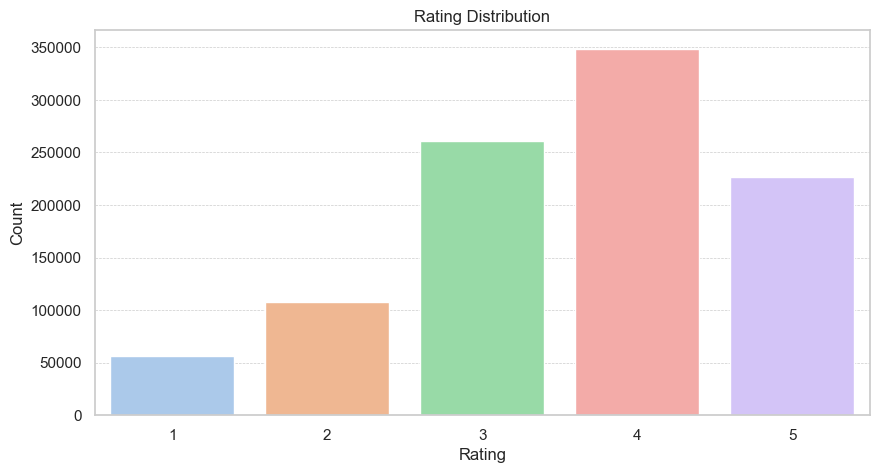

In [37]:
plt.figure(figsize=(10, 5))
rating_counts = df_ratings['rating'].value_counts().sort_index()
ratings_df = pd.DataFrame({'rating': rating_counts.index, 'count': rating_counts.values})
sns.barplot(data=ratings_df, x='rating', y='count', hue='rating', palette='pastel', legend=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [38]:
df_ratings = df_ratings[df_ratings['rating'] >= 4]
user_counts = df_ratings['user_id'].value_counts()
item_counts = df_ratings['movie_id'].value_counts()

print("User interaction percentiles:")
print(user_counts.describe(percentiles=[.1, .25, .5, .75, .9]))

print("\nItem interaction percentiles:")
print(item_counts.describe(percentiles=[.1, .25, .5, .75, .9]))

User interaction percentiles:
count    6038.000000
mean       95.276747
std       105.005005
min         1.000000
10%        17.000000
25%        27.000000
50%        58.000000
75%       124.000000
90%       225.000000
max      1435.000000
Name: count, dtype: float64

Item interaction percentiles:
count    3533.000000
mean      162.830739
std       285.798512
min         1.000000
10%         4.000000
25%        13.000000
50%        49.000000
75%       183.000000
90%       457.000000
max      2853.000000
Name: count, dtype: float64


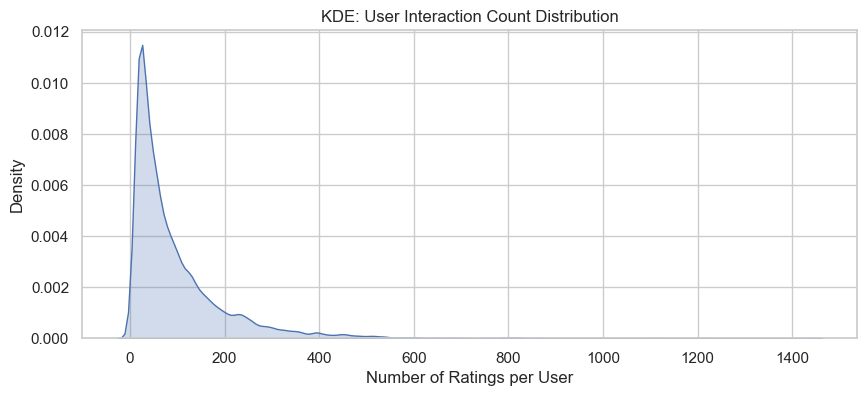

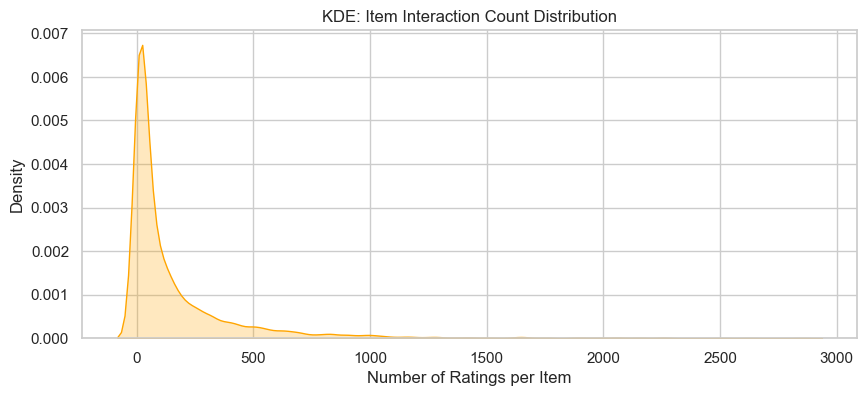

In [39]:
# --- KDE plot for user interactions ---
plt.figure(figsize=(10, 4))
sns.kdeplot(user_counts, fill=True, bw_adjust=0.5)
plt.title("KDE: User Interaction Count Distribution")
plt.xlabel("Number of Ratings per User")
plt.ylabel("Density")
plt.show()

# --- KDE plot for item interactions ---
plt.figure(figsize=(10, 4))
sns.kdeplot(item_counts, fill=True, color="orange", bw_adjust=0.5)
plt.title("KDE: Item Interaction Count Distribution")
plt.xlabel("Number of Ratings per Item")
plt.ylabel("Density")
plt.show()

# Movies metadata

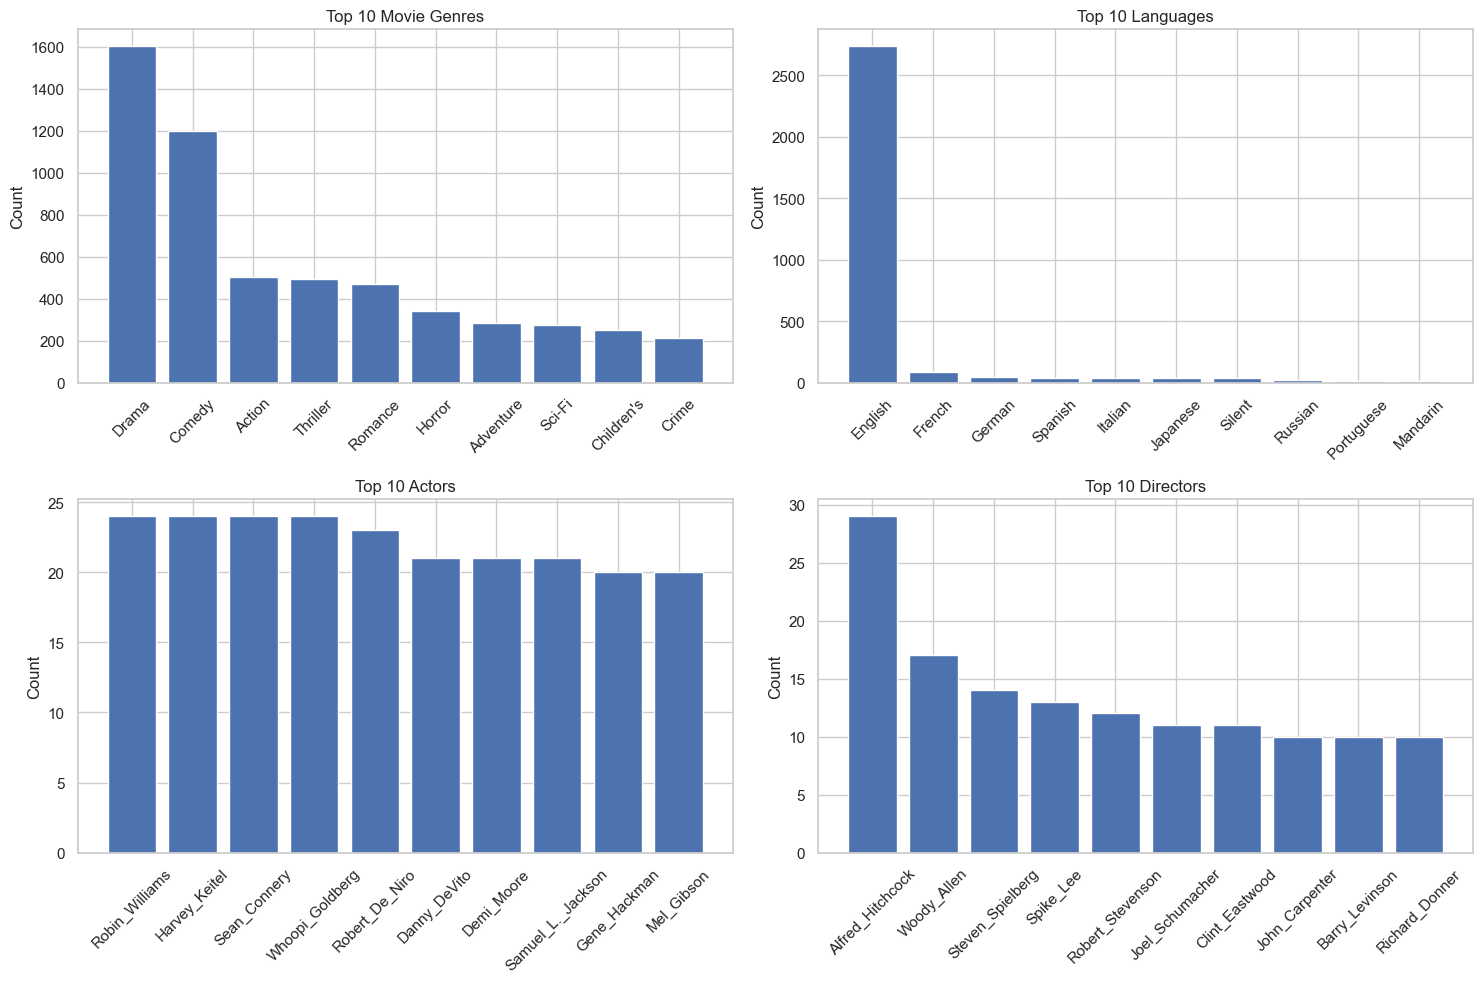

In [40]:
# Helper function to parse stringified list columns
def parse_list_column(col):
    return col.apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x != "['']" else [])

# Parse relevant columns
df_meta['genres_parsed'] = parse_list_column(df_meta['genres'])
df_meta['language_parsed'] = parse_list_column(df_meta['language'])
df_meta['actor_parsed'] = parse_list_column(df_meta['actor'])

# Get top N items from parsed lists
def get_top_counts(parsed_col, top_n=10):
    all_items = [item for sublist in parsed_col for item in sublist]
    return Counter(all_items).most_common(top_n)

# Compute top 10 items
top_genres = get_top_counts(df_meta['genres_parsed'])
top_languages = get_top_counts(df_meta['language_parsed'])
top_actors = get_top_counts(df_meta['actor_parsed'])
top_directors = df_meta['director'].dropna().value_counts().nlargest(10)

# Plotting helper
def plot_on_axis(ax, data, title, xlabel, ylabel):
    labels, values = zip(*data) if isinstance(data, list) else (data.index, data.values)
    ax.bar(labels, values)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)

# Create 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plot_on_axis(axs[0, 0], top_genres, "Top 10 Movie Genres", "", "Count")
plot_on_axis(axs[0, 1], top_languages, "Top 10 Languages", "", "Count")
plot_on_axis(axs[1, 0], top_actors, "Top 10 Actors", "", "Count")
plot_on_axis(axs[1, 1], top_directors, "Top 10 Directors", "", "Count")
plt.tight_layout()
plt.show()

# Users metadata

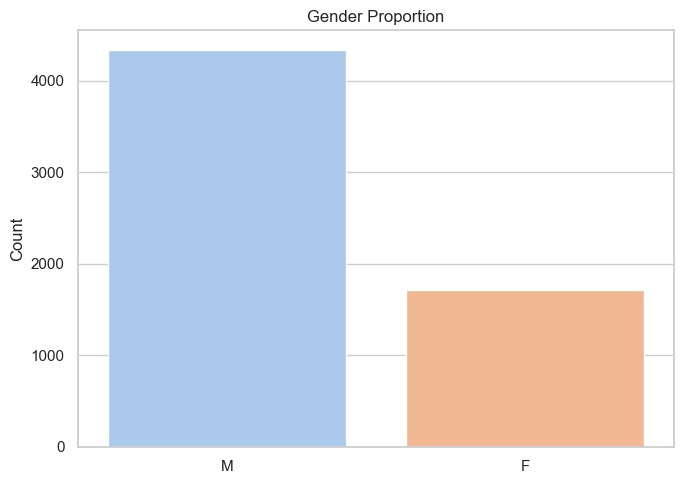

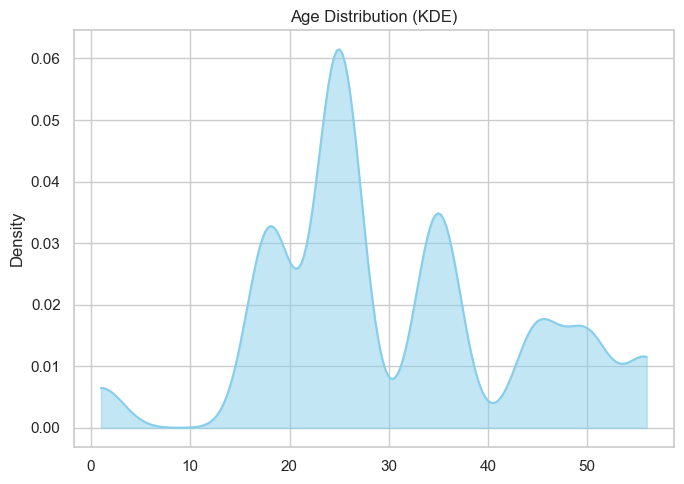

In [41]:
# Convert age to numeric and drop any invalid rows
df_users['age'] = pd.to_numeric(df_users['age'], errors='coerce')
df_users_clean = df_users.dropna(subset=['age'])
df_users_clean['age'] = df_users_clean['age'].astype(float)

# Gender counts from cleaned data
gender_counts_clean = df_users_clean['gender'].value_counts()

# --- Plot 1: Gender Proportion ---
plt.figure(figsize=(7, 5))
sns.barplot(x=gender_counts_clean.index, y=gender_counts_clean.values, hue=gender_counts_clean.index, palette='pastel', legend=False)
plt.title('Gender Proportion')
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# --- Plot 2: Age Distribution (KDE) ---
# Use scipy to compute KDE
age_data = df_users_clean['age'].values
kde = gaussian_kde(age_data)
x_vals = np.linspace(age_data.min(), age_data.max(), 200)
y_vals = kde(x_vals)

# Plot KDE
plt.figure(figsize=(7, 5))
plt.plot(x_vals, y_vals, color='skyblue')
plt.fill_between(x_vals, y_vals, color='skyblue', alpha=0.5)
plt.title('Age Distribution (KDE)')
plt.xlabel('')
plt.ylabel('Density')
plt.tight_layout()
plt.show()